# Volatility surface calibration
#### Dmitry Bazanov - MIPT
#### Roland Grinis - MIPT & GrinisRIT
#### Ivan Novikov - MIPT

In [2]:
import torch
from torch.utils.cpp_extension import load
import numpy as np
import numba as nb
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline
torch.manual_seed(987654);

## 1. Implied Volatility

#### 1.1 CDF Approximation
Zelen & Severo approximation for the standard normal CDF $\text{N}(x) = \frac{1}{\sqrt{2\pi}}\int^x_{-\infty} \text{d}z \exp(-z^2/2)$ is given by: 
$$
\text{N}(x) = 1 - \text{N}'(x) \sum_{i=1}^{5} b_i t^i + \epsilon (x)
$$
where $t = (1 + b_0 x)^{-1}$, the error is bounded by $|\epsilon (x)| < 7.5 \cdot 10^{-8}$ and the coefficients $b_i$ are fixed (see implementation).

$$
b_0 = 0.2316419 \\
b_1 = 0.319381530 \\
b_2 = -0.356563782 \\
b_3 = 1.781477937 \\
b_4 = -1.821255978 \\
b_5 = 1.330274429
$$

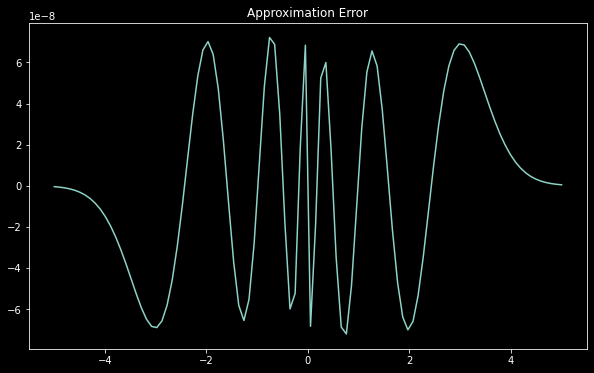

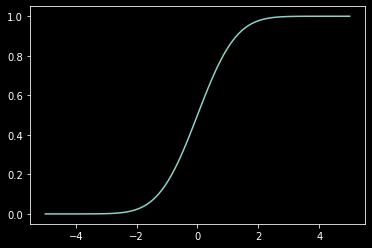

In [12]:
@nb.njit()
def cdf(x):
    t = 1 / (1 + 0.2316419*abs(x))
    summ = 0.319381530*t - 0.356563782*t**2 + 1.781477937*t**3 - 1.821255978*t**4 + 1.330274429*t**5
    if x >= 0:
        return 1 - summ * np.exp(-abs(x)**2 / 2) / np.sqrt(2*np.pi)
    else:
        return summ * np.exp(-abs(x)**2 / 2) / np.sqrt(2*np.pi)

x = np.linspace(-5, 5, 100)
N0 = norm.cdf(x)
N1 = tuple(map(cdf, x))

plt.style.use('dark_background')
plt.figure(figsize=(10,6))
plt.plot(x, N0 - np.array(N1))
plt.title('Approximation Error')
plt.show()

plt.plot(x, N1)

#### 1.2 Newton-Raphson

$$
g\left(\sigma_{\text {imp }}\right)=V^{m k t}(K, T)-V\left(t_0=0, S_0 ; K, T, \sigma_{\text {imp }}, r\right)=0 .
$$

Given an initial guess for the implied volatility, i.e. $\sigma_{\text {imp }}^{(0)}$, we can find the next approximations, $\sigma_{\text {imp }}^{(k)}, k=1,2, \ldots$, by means of the Newton-Raphson iterative algorythm, as follows

$$
\sigma_{\text {imp }}^{(k+1)}=\sigma_{\text {imp }}^{(k)}-\frac{g\left(\sigma_{\text {imp }}^{(k)}\right)}{g^{\prime}\left(\sigma_{\text {imp }}^{(k)}\right)}, \text { for } k \geq 0 .
$$


#### 1.3 Combined Algorythm (Newton-Raphson + Bisection):

Determine initial interval $\left[\sigma_{\text {imp }}^l, \sigma_{\text {imp }}^r\right]$
If $g\left(\sigma_{imp}^l\right) \cdot g\left(\sigma_{imp}^r\right)>0$ stop (there is no zero in the interval)

Else: 
$$
\delta=-\frac{g\left(\sigma_{imp}^{(k)}\right)} {g^{\prime}\left(\sigma_{imp}^{(k)}\right)}
$$
$$
\sigma_{imp}^{(0)} = \frac{1}{2} (\sigma_{imp}^l + \sigma_{imp}^r)
$$
While $\delta / \sigma_{imp}^{(k)}>$ tolerance:

$$
\sigma_{imp}^{(k+1)}=\sigma_{imp}^{(k)}+ \delta 
$$
$$
\text { if } \sigma_{imp}^{(k+1)} \notin \left[\sigma_{imp}^l, \sigma_{imp}^r\right]
$$
$$
\quad \text { if } g\left(\sigma_{imp}^l\right) \cdot g\left(\sigma_{imp}^{(k+1)}\right)>0 
\text { then } \sigma_{imp}^l=\sigma_{imp}^{(k)} 
$$
$$
\quad \text { if } g\left(\sigma_{imp}^l\right) \cdot g\left(\sigma_{imp}^{(k+1)}\right)<0 
\text { then } \sigma_{imp}^r=\sigma_{imp}^{(k)} 
$$
$$
\quad \sigma_{imp}^{(k+1)}=\left(\sigma_{imp}^l+\sigma_{imp}^r\right) / 2 
$$
$$
\delta=-g\left(\sigma_{imp}^{(k+1)}\right) / g^{\prime}\left(\sigma_{imp}^{(k+1)}\right) 
$$

In [13]:
@nb.njit()
def g(sigma, V_mkt, dt, s0, K, r, call=True):
    d1 = (np.log(s0/K) + (r + sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    d2 = d1 - sigma * np.sqrt(dt)
    p = 1 if call else -1
    # V = p*s0*norm.cdf(p*d1, 0,1) - p*K*np.exp(-r*dt)*norm.cdf(p*d2, 0,1)
    V = p*s0*cdf(p*d1) - p*K*np.exp(-r*dt)*cdf(p*d2)
    return V_mkt - V


@nb.njit()
def g_prime(sigma, dt, s0, K, r):
    dist = (np.log(s0/K) + (r - sigma**2/2)*dt) / (sigma*dt)
    return -K*np.exp(-r*dt) * np.sqrt(dt) * np.exp(-dist**2 / 2) / np.sqrt(2*np.pi)

@nb.njit()
def root_finder(V_mkt, dt, s0, K, r, call=True, tol=10**-8, sigma_l=10**-8, sigma_r=1):
    if g(sigma_l, V_mkt, dt, s0, K, r, call)*g(sigma_r, V_mkt, dt, s0, K, r, call) > 0:
        print('no zero at the initial interval')
    else:
        sigma = (sigma_l + sigma_r) / 2
        shift = - g(sigma, V_mkt, dt, s0, K, r, call) / g_prime(sigma, dt, s0, K, r)

        while shift / sigma > tol:
            sigma = sigma + shift
            if sigma > sigma_r or sigma < sigma_l:
                if g(sigma_l, V_mkt, dt, s0, K, r, call)*g(sigma, V_mkt, dt, s0, K, r, call) > 0:
                    sigma_l = sigma
                else:
                    sigma_r = sigma

                sigma = (sigma_l + sigma_r) / 2

            shift = - g(sigma, V_mkt, dt, s0, K, r, call) / g_prime(sigma, dt, s0, K, r)
        return sigma

In [14]:
root_finder(10, 1, 100, 150, 0.1)

0.5136388807425428

## 2. SABR calibration

This is a stochastic volatility model that describes the dynamics of the forward directly in the risk neutral measure:

$$ df_t = \alpha_t f_t^ dW_t^1\beta $$ 
$$ d \alpha_t = v \alpha_t f_t^ dW_t^2$$ 
$$E[dW_t^1, dW_t^2] = \rho dt$$

where $-1 < \rho < 1$ is the vol correlation, $0 \leq \beta \leq 1$ is the CIR exponent and the Wiener processes are independent.

Corrected implied vol parametrisation:
$$\sigma_B = \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(fK)^{1-\beta}} + \frac{\rho \beta v \alpha}{4(fK)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}v^2]T)}{(fK)^{(1-\beta)/2}[1+\frac{(1-\beta)^2}{24} \ln{(\frac{f}{K})}^2 + \frac{(1-\beta)^4}{1920} \ln{(\frac{f}{K})}^4]} * \frac{z}{\xi(z)}$$
$$z = \frac{v}{\alpha}(fK)^{(1-\beta)/2}\ln{(f/K)^2}$$
$$\xi(z) = \ln{[\frac{\sqrt{1-2z\rho+z^2}+z-\rho}{1-\rho}]}$$

Finding $\beta$:
$$\sigma_{ATM} = \sigma_{B} (f, f) =  \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(f)^{2-2\beta}} + \frac{\rho \beta v \alpha}{4(f)^{(1-\beta)}}+\frac{2-3\rho^2}{24}v^2]T)}{f^{1 - \beta}} $$

$$\ln \sigma_{ATM} \approx \ln \alpha - (1 - \beta) \ln {f}$$

$$ \ln \alpha - (1 - \beta) \ln {f} \sim \sigma^{market} $$

#### 2.1 Analytic formulae for gradients
$$x = \ln \frac{f}{K}$$

$$ \sigma_B(x, T) \approx I_B^0(x) (1 + I_H^1(x)T) = I_B^0(x) + I_B^0(x) \cdot I_H^1(x)T$$

$$I_H^1(x) = \frac{\alpha^{2} \left(K f\right)^{\beta - 1} \left(1 - \beta\right)^{2}}{24} + \frac{\alpha \beta \rho v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4} + \frac{v^{2} \cdot \left(2 - 3 \rho^{2}\right)}{24}$$


Derivatives of $I_H^1(x)$:

$$ \frac{\partial I_H^1(x)}{\partial \alpha} = \frac{\alpha \left(K f\right)^{\beta - 1} \left(1 - \beta\right)^{2}}{12} + \frac{\beta \rho v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4}$$

$$ \frac{\partial I_H^1(x)}{\partial \beta} = \frac{\alpha^{2} \left(K f\right)^{\beta - 1} \left(1 - \beta\right)^{2} \log{\left(K f \right)}}{24} + \frac{\alpha^{2} \left(K f\right)^{\beta - 1} \cdot \left(2 \beta - 2\right)}{24} + \frac{\alpha \beta \rho v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}} \log{\left(K f \right)}}{8} + \frac{\alpha \rho v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4} $$

$$ \frac{\partial I_H^1(x)}{\partial v} = \frac{\alpha \beta \rho \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4} + \frac{v \left(2 - 3 \rho^{2}\right)}{12}$$

$$ \frac{\partial I_H^1(x)}{\partial \rho} = \frac{\alpha \beta v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4} - \frac{\rho v^{2}}{4}$$



$\textbf{Case 1}: x = 0$ 
$$I_B^0 = \alpha K^{\beta - 1}$$

$$\frac{\partial I_B^0}{\partial \alpha} = K^{\beta - 1}$$
$$\frac{\partial I_B^0}{\partial \beta} = K^{\beta - 1} \alpha \ln{\left(K \right)}$$
$$\frac{\partial I_B^0}{\partial v} = 0 $$
$$\frac{\partial I_B^0}{\partial \rho} = 0 $$

$\textbf{Case 2}: v = 0$ 
$$I_B^0 = \frac{x\alpha(1 - \beta)}{f^{1 - \beta} - K^{1 - \beta}} $$

$$\frac{\partial I_B^0}{\partial \alpha} = \frac{x(1 - \beta)}{f^{1 - \beta} - K^{1 - \beta}}
$$
$$\frac{\partial I_B^0}{\partial \beta} = K^{\beta - 1} \alpha \ln{\left(K \right)}$$
$$\frac{\partial I_B^0}{\partial v} = 0 $$
$$\frac{\partial I_B^0}{\partial \rho} = 0 $$

$\textbf{Case 3}: \beta = 1$ 

$$z = \frac{v x}{\alpha}$$

$$\xi =  \sqrt{- 2 \rho z + z^{2} + 1} $$

$$I_B^0 = \frac{vx}{\ln \left( \frac{\xi + z - \rho}{1 - \rho} \right) } $$

$$\frac{\partial I_B^0}{\partial \alpha} = \frac{v x z}{\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}}$$


$$\frac{\partial I_B^0}{\partial \beta} = 0 $$


$$\frac{\partial I_B^0}{\partial v} = \frac{x \left(\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)} - v x\right)}{\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}}$$


$$\frac{\partial I_B^0}{\partial \rho} = \frac{v x \left(\left(\rho - 1\right) \left(z + \xi\right) + \left(- \rho + z + \xi\right) \xi\right)}{\left(\rho - 1\right) \left(- \rho + z + \xi\right) \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}} $$

$\textbf{Case 4}: \beta < 1$ 

$$z = \frac{v(f^{1 - \beta} - K^{1 - \beta})}{\alpha (1 - \beta)}$$

$$\xi =  \sqrt{- 2 \rho z + z^{2} + 1} $$

$$I_B^0 = \frac{vx}{\ln \left( \frac{\xi + z - \rho}{1 - \rho} \right) } $$

$$\frac{\partial I_B^0}{\partial \alpha} = \frac{v x z}{\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}} $$


$$\frac{\partial I_B^0}{\partial \beta} = \frac{v x \left( 
  \alpha (z^2 - \rho z + z \xi) - ( v z +  \rho v +  \xi v) \left(K^{1 - \beta} \log{\left(K \right)} - f^{1 - \beta} \log{\left(f \right)}\right))\right)}{\alpha \left(1 - \beta\right) \xi \left(- \rho + z + \xi\right) \log{\left(\frac{- \rho + z + \xi}{1 - \rho} \right)}^{2}} $$


$$\frac{\partial I_B^0}{\partial v} = - \frac{v x \left(\frac{- \frac{\rho z}{v} + \frac{z^{2}}{v}}{\xi} + \frac{z}{v}\right)}{\left(- \rho + z + \xi\right) \log{\left(\frac{- \rho + z + \xi}{1 - \rho} \right)}^{2}} + \frac{x}{\log{\left(\frac{- \rho + z + \xi}{1 - \rho} \right)}}$$


$$\frac{\partial I_B^0}{\partial \rho} = - \frac{v x \left(1 - \rho\right) \left(\frac{- \frac{z}{\xi} - 1}{1 - \rho} + \frac{- \rho + z + \xi}{\left(1 - \rho\right)^{2}}\right)}{\left(- \rho + z + \xi\right) \log{\left(\frac{- \rho + z + \xi}{1 - \rho} \right)}^{2}} $$

Final formulae for Jacobian:

$$ \frac{\partial \sigma_B(x, T)}{\partial \alpha} = \frac{I_B^0(x)}{\partial \alpha} (1 + I_H^1(x)T) +
\frac{I_H^1(x)}{\partial \alpha} I_B^0(x) T 
$$

$$ \frac{\partial \sigma_B(x, T)}{\partial \beta} = \frac{I_B^0(x)}{\partial \beta} (1 + I_H^1(x)T) +
\frac{I_H^1(x)}{\partial \beta} I_B^0(x) T 
$$

$$ \frac{\partial \sigma_B(x, T)}{\partial v} = \frac{I_B^0(x)}{\partial v} (1 + I_H^1(x)T) +
\frac{I_H^1(x)}{\partial v} I_B^0(x) T 
$$

$$ \frac{\partial \sigma_B(x, T)}{\partial \rho} = \frac{I_B^0(x)}{\partial \rho} (1 + I_H^1(x)T) +
\frac{I_H^1(x)}{\partial \rho} I_B^0(x) T 
$$

## 3. Heston calibration
This is a stochastic volatility model for the forward dynamics in the risk neutral measure, and CIR dynamics for the variance:
$$
\left\{
\begin{array}{l}
    \text{d}X_t =  \sqrt{V_t} X_t \text{d}W_t^X,  \\
    \text{d}V_t =  \kappa (\theta - V_t)\text{d}t + \varepsilon \sqrt{V_t} \text{d} W_t^V,
\end{array}\right.
$$

where underlying Brownian motions are correlated:
$$ \text{d} W_t^V = \rho\text{d}W_t^X + \sqrt{1-\rho^2} \text{d}W_t,$$
$$ -1 < \rho < 1 $$

The forward price of a call option is given by:
$$
\text{FV}_C(t_0, T, K) = X_{t_0} H(\sqrt{-1}) - K \cdot H(0)
$$
where
$$
H(z) = \frac{1}{2} + \frac{1}{\pi} \int^{\infty}_0 \mathbf{Re} \left[ \frac{e^{u\sqrt{-1} \log \frac{X_{t_0}}{K}}}{u\sqrt{-1}} \phi(u-z,T) \right]\text{d}u
$$
with 
$$
\phi(u,T) = \exp \left( - \frac{\kappa\theta\rho T u\sqrt{-1} }{\varepsilon} - A + \frac{2 \kappa \theta }{\varepsilon^2}D\right).
$$
Here $A = A_1 / A_2$:
$$
A_1 = (u^2 + u\sqrt{-1}) \sinh \frac{q T}{2}, \quad q = \sqrt{ \xi^2 + \varepsilon^2 (u^2 + u\sqrt{-1})}, \quad \xi = \kappa - \varepsilon\rho u\sqrt{-1}
$$
$$
\log A_2 = \frac{q T}{2} + \log \left( \frac{q +\xi}{2 V_{t_0}} + \frac{q  - \xi}{2V_{t_0}}e^{-q T}\right),
$$

and
$$
D = \log \frac{q}{V_{t_0}} + \frac{\kappa T}{2} - \log A_2.
$$

The integral above can be truncated to $(0,200)$ and evaluated via Gaussian quadrature at 64 nodes for $10^{-10}$ accuracy.

#### 3.1 Delta computation
See that:

$$\text{FV}_C(\lambda X_{t_0}, T, \lambda K) = \lambda \text{FV}_C(X_{t_0}, T, K).$$

So, formula is homogeneous of order one. Differentiating both sides with respect to $\lambda$:

$$X_{t_0} \frac{\partial \text{FV}_C}{\partial X_{t_0}} + K \frac{\partial \text{FV}_C}{\partial K} = \text{FV}_C.$$

Comparing with equation for call-option:

$$\Delta = \frac{\partial \text{FV}_C}{\partial X_{t_0}} = H(i).$$

#### 3.2 Estimating parameters before calibration

We can fix $\nu_0$ to $\sigma_{ATM}^2$ this way:

$$
\sigma_{ATM}^2 = 
 \begin{cases}
   \theta &\text{, $T >> 1$ }\\
   \nu_0 &\text{, $T << 1$ }
 \end{cases}
$$

In our case $\theta$ can not be fixed to ATM, because we work with short-term maturities

1. Take closest expiration
2. Take closest forward out of the money put и call option per this expiration
3. Find their implied volatilities with Newton-Raphsen
4. Take average-weighted as ATM implied volatility:

$$
\sigma(f, K = f) = \sigma_{iv_{left}}\frac{f - K_{left}}{K_{right} - K_{left}} + \sigma_{iv_{right}}\frac{K_{right} - f}{K_{right} - K_{left}}
$$


Taking $f_i$ daily historical data on forward price:

$$
r_{t_i} = \frac{f_{t_i} - f_{t_{i-1}} }{f_{t_{i-1}} \sqrt{\delta t}}
$$
$$
\delta t = t_i - t_{i-1}
$$
$$
\theta = \frac{1}{n_{max}} \sum\limits_{i=0}^{-n_{max}} \left( r_{t_i} - \frac{1}{n_{max} + 1} \sum\limits_{i=0}^{-n_{max}} r_{t_i} \right)^2
$$


Find $\theta$ and build linear regression to find $\kappa$, $\nu$:

$$\frac{\alpha_{t_{i+1}} - \alpha_{t_{i}}}{\sqrt{\alpha_{t_{i}}}}  = \frac{\theta \cdot \delta t - \alpha_{t_{i}}}{\sqrt{\alpha_{t_{i}}}} \cdot \kappa + \nu \sqrt{\delta t} \cdot \epsilon_i$$

### References
* Hagan, P. S. et al. *Implied volatility formulas for Heston models.* Wilmott 2018.98 (2018)
* Hagan, P.S., Lesniewski, A.S. and Woodward, D.E., *Managing vol surfaces*. Wilmott (93), pp.24-43, (2018)
* Bartlett, B. *Hedging Under SABR Model.* Wilmott Magazine, (2006)
* Oblój, J. *Fine-Tune Your Smile: Correction to Hagan et al*. preprint arXiv:0708.0998 (2007)
* Paulot, L. *Asymptotic implied volatility at the second order with application to the SABR model.* In Large Deviations and Asymptotic Methods in Finance (pp. 37-69). Springer, Cham. (2015)
* Henry-Labordere, P. *A general asymptotic implied volatility for stochastic volatility models.* http://arxiv.org/abs/cond-mat/0504317 (2005)